# Test vgg16 accuracy convert from PyTorch

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import os
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/home/peter/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [3]:
caffe.set_mode_cpu()

model_def =  'vgg16-pytorch2caffe.prototxt'
model_weights = 'vgg16-pytorch2caffe.caffemodel' 

net = caffe.Net(model_def,      # defies the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [4]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
#mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
#mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
#print 'mean-subtracted values:', zip('BGR', mu)
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
#transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
#transformer.set_raw_scale('data', 255)

#transformer.set_var('data', var)
#transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [5]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

In [22]:
# copy the image data into the memory allocated for the net
image = caffe.io.load_image('data/dog.jpg')

mu = [ 0.485, 0.456, 0.406] # RGB 
#mu = [ 0.406, 0.456, 0.485] # BGR 
#print mu
image = image - mu
print 'Image dimension=', image.shape
#print image
#image = image /255
std = [ 0.229, 0.224, 0.225]
#print std[0]
image[:,:,0] = image[:,:,0]/std[0]  #RGB std by pytorch imagenet example
image[:,:,1] = image[:,:,1]/std[1]  #RGB std by pytorch imagenet example
image[:,:,2] = image[:,:,2]/std[2]  #RGB std by pytorch imagenet example

#image = image[:,:,0:3]  / [ 0.225, 0.224, 0.229]  #BGR std by pytorch imagenet example
#print image[0:5,0,0]
transformed_image = transformer.preprocess('data', image)
#plt.imshow(image)

Image dimension= (576, 768, 3)


In [23]:

net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['AddmmBackward38'][0]  # the output probability vector for the first image in the batch



In [24]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
    
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

#print 'output label:', labels[output_prob.argmax()]

In [9]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items
print top_inds

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])



[249 537 250 248 196]
probabilities and labels:


[(0.38207737, 'n02110063 malamute, malemute, Alaskan malamute'),
 (0.17119314, 'n03218198 dogsled, dog sled, dog sleigh'),
 (0.12900849, 'n02110185 Siberian husky'),
 (0.10763203, 'n02109961 Eskimo dog, husky'),
 (0.10001362, 'n02097047 miniature schnauzer')]

* We see that less confident predictions are sensible.

### 4. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [10]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
ConvNdBackward1	(1, 64, 224, 224)
ConvNdBackward3	(1, 64, 224, 224)
MaxPool2dBackward5	(1, 64, 112, 112)
ConvNdBackward6	(1, 128, 112, 112)
ConvNdBackward8	(1, 128, 112, 112)
MaxPool2dBackward10	(1, 128, 56, 56)
ConvNdBackward11	(1, 256, 56, 56)
ConvNdBackward13	(1, 256, 56, 56)
ConvNdBackward15	(1, 256, 56, 56)
MaxPool2dBackward17	(1, 256, 28, 28)
ConvNdBackward18	(1, 512, 28, 28)
ConvNdBackward20	(1, 512, 28, 28)
ConvNdBackward22	(1, 512, 28, 28)
MaxPool2dBackward24	(1, 512, 14, 14)
ConvNdBackward25	(1, 512, 14, 14)
ConvNdBackward27	(1, 512, 14, 14)
ConvNdBackward29	(1, 512, 14, 14)
MaxPool2dBackward31	(1, 512, 7, 7)
AddmmBackward32	(1, 4096)
AddmmBackward35	(1, 4096)
AddmmBackward38	(1, 1000)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [11]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

ConvNdBackward1	(64, 3, 3, 3) (64,)
ConvNdBackward3	(64, 64, 3, 3) (64,)
ConvNdBackward6	(128, 64, 3, 3) (128,)
ConvNdBackward8	(128, 128, 3, 3) (128,)
ConvNdBackward11	(256, 128, 3, 3) (256,)
ConvNdBackward13	(256, 256, 3, 3) (256,)
ConvNdBackward15	(256, 256, 3, 3) (256,)
ConvNdBackward18	(512, 256, 3, 3) (512,)
ConvNdBackward20	(512, 512, 3, 3) (512,)
ConvNdBackward22	(512, 512, 3, 3) (512,)
ConvNdBackward25	(512, 512, 3, 3) (512,)
ConvNdBackward27	(512, 512, 3, 3) (512,)
ConvNdBackward29	(512, 512, 3, 3) (512,)
AddmmBackward32	(4096, 25088) (4096,)
AddmmBackward35	(4096, 4096) (4096,)
AddmmBackward38	(1000, 4096) (1000,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [12]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

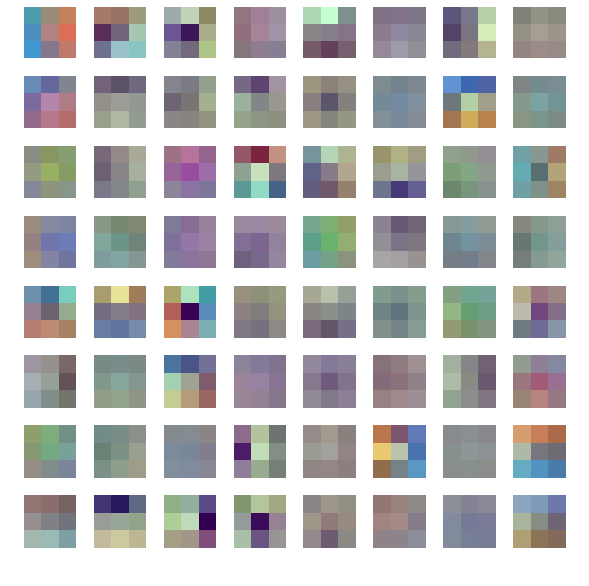

In [13]:
# the parameters are a list of [weights, biases]
filters = net.params['ConvNdBackward1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

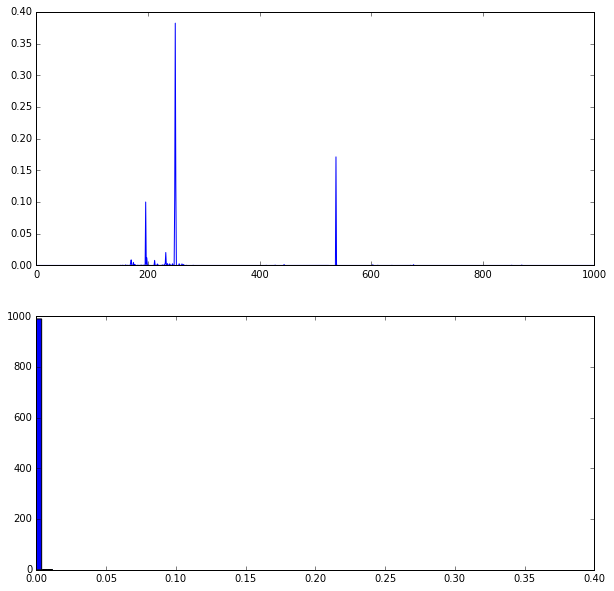

In [14]:
feat = net.blobs['AddmmBackward38'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Test Original Pytorch Vgg16

In [16]:
import sys
sys.path.append('/data/temp/caffe/python')
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torch.autograd import Variable
import torchvision
from visualize import make_dot
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
m = torchvision.models.vgg16(pretrained=True)
m.classifier.add_module('softmax', torch.nn.Softmax())
m.eval() # very important here, otherwise batchnorm running_mean, running_var will be incorrect
#input_var = Variable(torch.rand(1, 3, 224, 224))

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

<PIL.Image.Image image mode=RGB size=768x576 at 0x7F1A80486BD0>


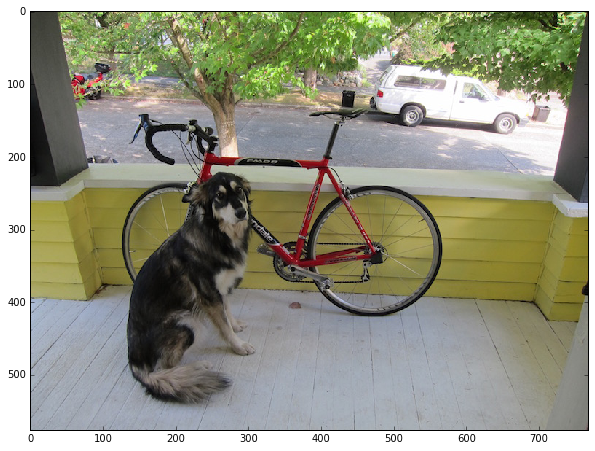

In [17]:
#from argparse.test_options import TestOptions

# Load image
real = Image.open('data/dog.jpg').convert('RGB')
print real
#I = torch.from_numpy(real.transpose([2,0,1])).float()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
transforms.Scale([224,224]),
#transforms.CenterCrop(224),
transforms.ToTensor(),
normalize,
])  

plt.imshow(real)


In [18]:
# Load input
input_A = preprocess(real)
print input_A[0,0:5,0]
input_A = input_A.unsqueeze(0)
input_A = Variable(input_A)
output = m.forward(input_A)


-1.1075
-1.1075
-1.0904
-1.0904
-1.0904
[torch.FloatTensor of size 5]



In [19]:
# Pytorch result
_, pred = torch.sort(output.data,1,True)
print('TOP 10 classes: ',pred[0,0:10] , _[0,0:10])
#print output.data.sort()



('TOP 10 classes: ', 
 249
 250
 537
 248
 196
 232
 169
 212
 176
 235
[torch.LongTensor of size 10]
, 
 0.3519
 0.1444
 0.1184
 0.0876
 0.0429
 0.0219
 0.0194
 0.0176
 0.0141
 0.0131
[torch.FloatTensor of size 10]
)


In [20]:
# CAFFE result
top_inds = output_prob.argsort()[::-1][:10]  # reverse sort and take five largest items
print top_inds


print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

[249 537 250 248 196 232 198 170 212 174]
probabilities and labels:


[(0.38207737, 'n02110063 malamute, malemute, Alaskan malamute'),
 (0.17119314, 'n03218198 dogsled, dog sled, dog sleigh'),
 (0.12900849, 'n02110185 Siberian husky'),
 (0.10763203, 'n02109961 Eskimo dog, husky'),
 (0.10001362, 'n02097047 miniature schnauzer'),
 (0.020427395, 'n02106166 Border collie'),
 (0.012015383, 'n02097209 standard schnauzer'),
 (0.0087743001, 'n02090721 Irish wolfhound'),
 (0.0079997424, 'n02100735 English setter'),
 (0.004818344, 'n02091467 Norwegian elkhound, elkhound')]